# HAM10000 Project


In [ ]:
import pandas as pd
import numpy as np


import os
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt



import torch


from torch.utils.data import Dataset, DataLoader, random_split



from torchvision.io import read_image


from torchvision import transforms, models



# Constants
SEED = 4
DATA_DIR = "../data/ham10k_data/"
PATH_TO_METADATA_FILE = DATA_DIR + "HAM10000_metadata.csv"
PATH_TO_IMAGES = DATA_DIR + "HAM10000_images/"


BATCH_SIZE = 512


VALIDATION_SPLIT = 0.2


EPOCHS = 10

# read in metadata
metadata_df = pd.read_csv(PATH_TO_METADATA_FILE)
metadata_df.head()

# map label to numeric
label_map = {
    label: i for i, label in enumerate(metadata_df["dx"].unique())
}
print(label_map)
metadata_df["dx"] = metadata_df["dx"].map(label_map)
print(metadata_df.head())

{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}
     lesion_id      image_id  dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419   0   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030   0   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769   0   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661   0   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633   0   histo  75.0  male          ear


In [81]:
train_df, test_df = train_test_split(
    metadata_df, test_size=0.3, shuffle=True, random_state=SEED
)

test_df, val_df = train_test_split(
    test_df, test_size=0.5, shuffle=True, random_state=SEED
)

In [82]:
print(len(train_df))
print(len(test_df))
print(len(val_df))

7010
1502
1503


In [83]:
print(train_df["dx"].value_counts())
print(test_df["dx"].value_counts())
print(val_df["dx"].value_counts())

dx
1    4692
0     786
3     770
5     362
6     218
4      97
2      85
Name: count, dtype: int64
dx
1    1005
3     173
0     161
5      77
6      50
4      25
2      11
Name: count, dtype: int64
dx
1    1008
3     170
0     152
5      75
6      59
4      20
2      19
Name: count, dtype: int64


In [84]:
# define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[
                         0.5, 0.5, 0.5])  # Normalize
])

# create dataset class to be used with dataloader one for train and one for test


class HAMDataset(Dataset):
    def __init__(self, df, path_to_images=PATH_TO_IMAGES, transform=None):
        self.path_to_images = path_to_images
        self.transform = transform

        # image labels from csv file, create df
        self.image_name = df["image_id"]
        self.image_labels = df["dx"]

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, index):
        # index and first column (holds img_names)
        image_path = os.path.join(
            self.path_to_images, self.image_name.iloc[index] + ".jpg")

        # read in the image using torchvision.io.read_image func
        image = read_image(image_path)

        # transform if there are transformations
        if self.transform:
            image = self.transform(image)

        # get label from df (second col)
        label = self.image_labels.iloc[index]

        return image, label


# get train dataset
ham_train_dataset = HAMDataset(
    train_df, transform=transform)

# get train dataset
ham_val_dataset = HAMDataset(
    val_df, transform=transform)

# get train dataset
ham_test_dataset = HAMDataset(
    test_df, transform=transform)


# create dataloaders
train_dataloader = DataLoader(
    ham_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataloader = DataLoader(
    ham_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataloader = DataLoader(
    ham_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

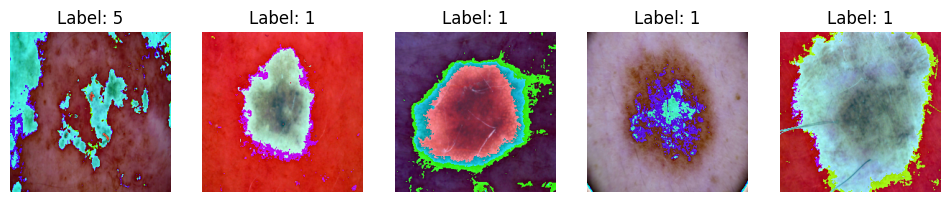

In [85]:
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Convert tensor to PIL image
        plt.imshow(transforms.ToPILImage()(images[i]))
        plt.axis("off")

        plt.title(f"Label: {labels[i]}")

    plt.show()


# Get a batch of images and labels from the train dataloader
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

# Show the images with their corresponding labels
show_images(images, labels)

In [86]:
# use transfer learning on pretrained model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# get modle number of input features
num_input_features = model.classifier[1].in_features

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier (final fully connected layers)
for param in model.classifier.parameters():
    param.requires_grad = True

# replace classifier with a custom one
model.classifier = torch.nn.Sequential(
    # Add a dense layer with 256 units
    torch.nn.Linear(num_input_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(256, 7)  # 7 classes
)

# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# set model criteria
criterion = torch.nn.CrossEntropyLoss()

# set model optimizer
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [87]:
# create function to train the nn
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):

    # message which epoch we are on
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1} / {epochs}")

        # start training phase
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            # move to GPU if available
            # images, labels = images.to(device), labels.to(device)
            images = images.to(device)
            labels = labels.to(device)

            # zero out gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(images)

            # compute loss
            loss = criterion(outputs, labels)

            # back prop
            loss.backward()

            # update weights
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()

            total += labels.size(0)

        train_accuracy = 100 * correct / total
        print(
            f"Train Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = 100 * correct / total
        print(
            f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%\n")

In [88]:
train_model(model=model, train_loader=train_dataloader, val_loader=val_dataloader,
            criterion=criterion, optimizer=optimizer, epochs=EPOCHS)

Epoch 1 / 10


KeyboardInterrupt: 

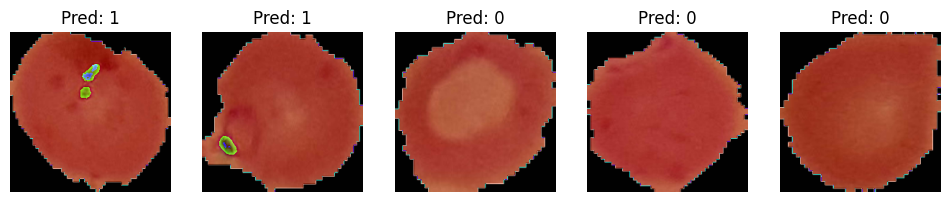

In [ ]:
# Make predictions on test
model.eval()

# Lists to store predictions and filenames
predictions = []
filenames = []

# Iterate through test data
with torch.no_grad():
    for images, image_names in test_dataloader:
        images = images.to(device)  # Move to GPU if available
        outputs = model(images)  # Get model outputs
        _, predicted = torch.max(outputs, 1)  # Get predicted class labels

        # Convert to CPU and store predictions
        predictions.extend(predicted.cpu().numpy())
        filenames.extend(image_names)  # Store filenames

# Save predictions to a CSV file
output_df = pd.DataFrame({
    'img_name': filenames,
    'label': predictions
})

output_df.to_csv('../predictions.csv', index=False)


def show_predicted_images(images, labels, num_images=5):
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(transforms.ToPILImage()(images[i]))
        plt.axis("off")
        plt.title(f'Pred: {labels[i]}')

    plt.show()


# Get a batch of test images and display predictions
data_iter = iter(test_dataloader)
images, _ = next(data_iter)
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Display the predicted images
show_predicted_images(images, predicted.cpu().numpy())